<h1>Part 3: feature engineering</h1>

**Loading necessarry libraries**


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from nltk.sentiment import SentimentIntensityAnalyzer  

**Loading the data and converting df["Review"] to string for safety**

In [2]:
df = pd.read_csv("train_cleaned.csv")
df["Review"] = df["Review"].astype(str)

**Defining new labels** <br>
After empirical tests we have concluded that 5 labels are superflous - 
the models classified 2s as 1s and 4s as 5s. We tested the following approaches: 

1. Transforming the labels with function f, where f(1, 2) = 0, f(3, 4) = 1, f(5) = 2
2. Transforming the labels with function g, where g(1, 2) = 0, g(3) = 1, g(4, 5) = 2
3. Defining new sentiment-based labels using VADER

The third approach yielded superior results; thus, we sticked to it.

In [3]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

def sentiment_to_discrete(sent):
    if sent >= 0.05:
        return 2
    elif sent <= -0.05:
        return 0
    else:
        return 1

df['sentiment'] = df['sentiment'].apply(sentiment_to_discrete)

In [4]:
df['sentiment'].describe()


count    81245.000000
mean         1.755013
std          0.567854
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: sentiment, dtype: float64

**TF-IDF** <br>
We configure TF-IDF for unigrams, bigrams and trigrams to capture the semantic 
meaning of multi-word phrases, but to simultaneously avoid capturing too much noise and random sequences.
We set max_features to 3000 due to computational limitations.

In [5]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=3000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Review"])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.shape

(81245, 3000)

**Scaling** <br>
Before applying PCA we scaled the data to N(0,1).

In [6]:
standardizer = StandardScaler()
tfidf_df= pd.DataFrame(standardizer.fit_transform(tfidf_df), columns=tfidf_df.columns)

**PCA** <br>
First, let's visualise the explainable variance.

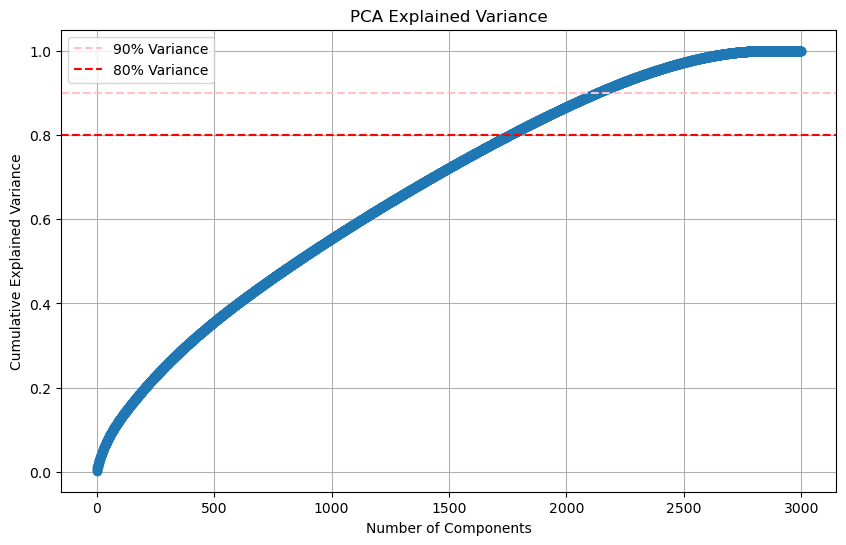

In [7]:
# Fit PCA to compute all components (but don't reduce yet)
pca = PCA().fit(tfidf_df)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(0.90, color='pink', linestyle='--', label='90% Variance') 
plt.axhline(0.80, color='red', linestyle='--', label='80% Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid()
plt.show()

**Reducing to 90% explainable variance**

In [8]:
pca_90 = PCA(n_components=0.90)  
tfidf_df = pca_90.fit_transform(tfidf_df)
print(f"Reduced to {tfidf_df.shape[1]} components")

Reduced to 2133 components


In [9]:
tfidf_df = pd.DataFrame(tfidf_df)
tfidf_df.shape

(81245, 2133)

In [10]:
df = pd.concat([tfidf_df, df[["sentiment"]]])
df.to_csv("train_final.csv")